In [ ]:
using NPZ
using LinearAlgebra
using SparseArrays
using JLD2
using Plots
# H = npzread("h2o_jwcas_ham.npy")
H = npzread("h6_linear_op_equi.npy")

In [ ]:
nstates = 3
eigvals, eigvecs = eigen(H)
ground_idx = argmin(real(eigvals))
ground_energy = real(eigvals[ground_idx])

# Select multiple states (lowest nstates)
state_indices = sortperm(real(eigvals))[1:nstates]
vecs = [eigvecs[:, idx] for idx in state_indices]
energies_exact = real(eigvals[state_indices])
N = size(H, 1)
n_qubits = Int(log2(N))
# calculate pairs
n = n_qubits * (n_qubits - 1) ÷ 2
println("n_qubits: ", n_qubits, ", N: ", N, ", n_pairs: ", n)
pspace_dims = collect(1:N)
cepa_approx_all = zeros(length(pspace_dims), nstates)
acpf_total_all = zeros(length(pspace_dims), nstates)
aqcc_total_all = zeros(length(pspace_dims), nstates)
bare_energy_all = zeros(length(pspace_dims), nstates)
pt2_total_all = zeros(length(pspace_dims), nstates)
rediag_energy_all = zeros(length(pspace_dims), nstates)
cepa_rediag_all = zeros(length(pspace_dims), nstates)
pt2_rediag_all = zeros(length(pspace_dims), nstates)

In [ ]:
for (istate, v) in enumerate(vecs)
    weight_order = sortperm(v; by=abs2, rev=true)
    for (i, p) in enumerate(pspace_dims)
        # Partition indices
        P = weight_order[1:p]
        Q = setdiff(1:N, P)
        # Projected reference
        Pv = zeros(eltype(v), N)
        Pv[P] = v[P]
        Pv_norm = Pv / norm(Pv)
        # Excited/configurational space
        Px = zeros(eltype(v), N)
        Px[Q] = v[Q]
        Px_norm = Px / norm(Px)

        # Compute block matrices
        # H_aa: scalar (projected reference sector)
        H_aa = real(Pv_norm' * H * Pv_norm)
        # H_ax: 1 × length(Q) (coupling between ref and expanded/configurational)
        H_ax = (Pv_norm'*H)[:, Q]
        # H_xa: transpose
        H_xa = (H*Pv_norm)[Q]
        # H_xx: outer configurational block
        H_xx = Matrix(H[Q, Q])

        # CEPA-0 amplitude equation: (H_xx - H_aa) * C_x = S_xa*H_aa-H_xa
        A = H_xx - H_aa * I(length(Q))
        # If using overlap (non-orthonormal), compute denominator:
        # Scalar overlap
        S_ax = dot(Pv_norm, Px_norm)
        S_xa = S_ax
        b = S_xa * H_aa .- H_xa
        C_x = pinv(A) * b            # Solve for amplitudes
        denom = 1 + S_ax * sum(C_x)
        if isnan(denom) || iszero(denom) || !isreal(denom)
            println("skipping p=$p, istate=$istate due to bad denom")
            denom = 1.0 # or skip, report, or regularize
        end
        E_cepa = real((H_aa + dot(H_ax, C_x)) / denom)
        cepa_approx_all[i, istate] = E_cepa
        println("p=$p, istate=$istate, E_cepa=$E_cepa, exact=$(energies_exact[istate])")

        # Store bare projected reference energy
        bare_energy_all[i, istate] = H_aa   # Projected ref energy
        println("p=$p, istate=$istate, E_bare=$(H_aa)")

        # ACPF correction
        shift_acpf = (E_cepa - H_aa) * 2.0 / n
        E_acpf = E_cepa + shift_acpf
        acpf_total_all[i, istate] = E_acpf
        println("p=$p, istate=$istate, E_acpf=$E_acpf")

        # AQCC correction
        shift_aqcc = (1.0 - (n - 3.0) * (n - 2.0) / (n * (n - 1.0))) * (E_cepa - H_aa)
        E_aqcc = E_cepa + shift_aqcc
        aqcc_total_all[i, istate] = E_aqcc
        println("p=$p, istate=$istate, E_acpf=$E_acpf, E_aqcc=$E_aqcc")

        # PT2 correction
        # PT2 correction using pseudo-inverse
        H_xx_diag = diag(H_xx)
        # PT2 = sum(abs2.(H_ax) ./ (H_aa .- H_xx_diag))
        PT2 = dot(H_ax, pinv(H_aa * I(length(Q)) .- H_xx_diag) * H_xa)
        pt2_total_all[i, istate] = H_aa + PT2
        println("p=$p, istate=$istate, PT2=$PT2, E_PT2=$(H_aa + PT2)")

        # Rediagonalize Hamiltonian in P space
        H_P = Matrix(H[P, P])
        eigvals_P, eigvecs_P = eigen(H_P)
        num_min = min(3, length(eigvals_P))
        min_eig_P = partialsort(real(eigvals_P), 1:num_min)
        v_Pmin = eigvecs_P[:, argmin(real(eigvals_P))]
        v_P_full = zeros(N)
        v_P_full[P] = v_Pmin                      # Embedding
        if size(min_eig_P)[1] < istate
            println("skipping p=$p, istate=$istate due to insufficient states in P")
            continue
        end
        rediag_energy_all[i, istate] = real(min_eig_P[istate])
        println("p=$p, istate=$istate, E_rediag=$(real(min_eig_P[istate]))")

        # Use embedded state for couplings
        H_aa_r = min_eig_P[istate]
        H_ax_r = (v_P_full'*H)[:, Q]
        H_xa_r = (H*v_P_full)[Q]
        A_r = H_xx - H_aa_r * I(length(Q))
        b_r = S_xa * H_aa_r .- H_xa_r
        C_x_r = pinv(A_r) * b_r
        denom_r = 1 + S_ax * sum(C_x_r)
        if isnan(denom_r) || iszero(denom_r) || !isreal(denom_r)
            println("skipping p=$p, istate=$istate due to bad denom_r")
            denom_r = 1.0
        end
        E_cepa_r = real((H_aa_r + dot(H_ax_r, C_x_r)) / denom_r)
        cepa_rediag_all[i, istate]= E_cepa_r
        println("p=$p, istate=$istate, E_cepa_r=$E_cepa_r, exact=$(energies_exact[istate])")

        # PT2 in Rediagonalized space
        E0 = min_eig_P[istate]
        # PT2_r = sum(abs2.(H_ax_r) ./ (E0 .- H_xx_diag))
        PT2_r = dot(H_ax_r, pinv(E0 * I(length(Q)) .- H_xx_diag) * H_xa_r)
        pt2_rediag_all[i, istate] = E0 + PT2_r
        println("p=$p, istate=$istate, PT2_r=$PT2_r, E_PT2_r=$(E0 + PT2_r)")

    end
end


In [ ]:
@show pspace_dims
@show minimum(pspace_dims)
@show maximum(pspace_dims)


In [ ]:
plot()
istate = 1
plot(pspace_dims, cepa_approx_all[:, istate], label="CEPA-0", lw=2)
plot!(pspace_dims, bare_energy_all[:, istate], label="Projected Ref")
plot!(pspace_dims, fill(energies_exact[istate], length(pspace_dims)), label="Exact")
plot!(pspace_dims, rediag_energy_all[:, istate], label="Rediag Ref", lw=2)
plot!(pspace_dims, cepa_rediag_all[:, istate], label="CEPA-0 Rediag", lw=2)
plot!(pspace_dims, pt2_rediag_all[:, istate], label="PT2 Rediag", lw=2)
# # plot!(pspace_dims, acpf_total_all[:, istate] , label="ACPF", lw=2)
# # plot!(pspace_dims, aqcc_total_all[:, istate] , label="AQCC", lw=2)
plot!(pspace_dims, pt2_total_all[:, istate], label="PT2", lw=2)
# xlabel!("P-space dimension")
# ylabel!("Energy (a.u.)")
title!("H6 Linear - State $(istate) Energy Convergence")
# savefig("h6_linear_cepa0_convergence_state$(istate).png")

In [ ]:
plot()
istate = 1
plot(pspace_dims, log.(abs.(energies_exact[istate] .- cepa_approx_all[:, istate])),
     label="CEPA-0", lw=2, color=:blue)
plot!(pspace_dims, log.(abs.(bare_energy_all[:, istate] .- energies_exact[istate])),
      label="Projected Ref", color=:orange)
plot!(pspace_dims, log.(abs.(rediag_energy_all[:, istate] .- energies_exact[istate])),
      label="Rediag Ref", lw=2, color=:green)
plot!(pspace_dims, log.(abs.(energies_exact[istate] .- cepa_rediag_all[:, istate])),
      label="CEPA-0 Rediag", lw=2, color=:red)
plot!(pspace_dims, log.(abs.(pt2_rediag_all[:, istate] .- energies_exact[istate])),
      label="PT2 Rediag", lw=2, color=:magenta)
plot!(pspace_dims, log.(abs.(pt2_total_all[:, istate] .- energies_exact[istate])),
      label="PT2", lw=2, color=:black)

# xlabel!("P-space dimension")
# ylabel!("Energy (a.u.)")
plot!(xscale=:log10)
title!("H6 Linear - State $(istate) Energy Convergence")
# savefig("h6_linear_logscalecepa0_pt2_convergence_state$(istate).png")

In [ ]:
plot()
istate = 2
plot(pspace_dims, log.(abs.(energies_exact[istate] .- cepa_approx_all[:, istate])),
     label="CEPA-0", lw=2, color=:blue)
plot!(pspace_dims, log.(abs.(bare_energy_all[:, istate] .- energies_exact[istate])),
      label="Projected Ref", color=:orange)
plot!(pspace_dims, log.(abs.(rediag_energy_all[:, istate] .- energies_exact[istate])),
      label="Rediag Ref", lw=2, color=:green)
plot!(pspace_dims, log.(abs.(energies_exact[istate] .- cepa_rediag_all[:, istate])),
      label="CEPA-0 Rediag", lw=2, color=:red)
plot!(pspace_dims, log.(abs.(pt2_rediag_all[:, istate] .- energies_exact[istate])),
      label="PT2 Rediag", lw=2, color=:magenta)
plot!(pspace_dims, log.(abs.(pt2_total_all[:, istate] .- energies_exact[istate])),
      label="PT2", lw=2, color=:black)

# xlabel!("P-space dimension")
# ylabel!("Energy (a.u.)")
plot!(xscale=:log10)
title!("H6 Linear - State $(istate) Energy Convergence")
# savefig("h6_linear_logscalecepa0_pt2_convergence_state$(istate).png")

In [ ]:
plot()
istate = 3
plot(pspace_dims, log.(abs.(energies_exact[istate] .- cepa_approx_all[:, istate])),
     label="CEPA-0", lw=2, color=:blue)
plot!(pspace_dims, log.(abs.(bare_energy_all[:, istate] .- energies_exact[istate])),
      label="Projected Ref", color=:orange)
plot!(pspace_dims, log.(abs.(rediag_energy_all[:, istate] .- energies_exact[istate])),
      label="Rediag Ref", lw=2, color=:green)
plot!(pspace_dims, log.(abs.(energies_exact[istate] .- cepa_rediag_all[:, istate])),
      label="CEPA-0 Rediag", lw=2, color=:red)
plot!(pspace_dims, log.(abs.(pt2_rediag_all[:, istate] .- energies_exact[istate])),
      label="PT2 Rediag", lw=2, color=:magenta)
plot!(pspace_dims, log.(abs.(pt2_total_all[:, istate] .- energies_exact[istate])),
      label="PT2", lw=2, color=:black)

# xlabel!("P-space dimension")
# ylabel!("Energy (a.u.)")
plot!(xscale=:log10)
title!("H6 Linear - State $(istate) Energy Convergence")
# savefig("h6_linear_logscalecepa0_pt2_convergence_state$(istate).png")

In [ ]:
println("projected ref energy: ", bare_energy_all[end, :])
println("rediagonalized ref energy: ", rediag_energy_all[end, :])

In [ ]:
println("CEPA-0 energy: ", cepa_approx_all[end, :])
println("pt2 energy: ", pt2_total_all[end, :])

In [ ]:
plot()
istate = 2
plot(pspace_dims, cepa_approx_all[:, istate], label="CEPA-0", lw=2)
plot!(pspace_dims, bare_energy_all[:, istate], label="Projected Ref")
plot!(pspace_dims, fill(energies_exact[istate], length(pspace_dims)), label="Exact")
plot!(pspace_dims, acpf_total_all[:, istate], label="ACPF", lw=2)
plot!(pspace_dims, aqcc_total_all[:, istate], label="AQCC", lw=2)
plot!(pspace_dims, pt2_total_all[:, istate], label="PT2", lw=2)
xlabel!("P-space dimension")
ylabel!("Energy (a.u.)")
plot!(legend=:right)
title!("H6 Linear - State $(istate) Energy Convergence")
# savefig("h6_linear_cepa0_convergence_state$(istate).png")

In [ ]:
plot()
istate = 3
plot(pspace_dims, cepa_approx_all[:, istate], label="CEPA-0", lw=2)
plot!(pspace_dims, bare_energy_all[:, istate], label="Projected Ref")
plot!(pspace_dims, fill(energies_exact[istate], length(pspace_dims)), label="Exact")
plot!(pspace_dims, acpf_total_all[:, istate], label="ACPF", lw=2)
plot!(pspace_dims, aqcc_total_all[:, istate], label="AQCC", lw=2)
# plot!(pspace_dims, pt2_total_all[:, istate] , label="PT2", lw=2)
xlabel!("P-space dimension")
ylabel!("Energy (a.u.)")
plot!(legend=:right)
title!("H6 Linear - State $(istate) Energy Convergence")
# savefig("h6_linear_cepa0_convergence_state$(istate).png")

In [ ]:
plot()
istate = 3
plot!(pspace_dims[1:N], cepa_approx_all[1:N, istate], label="CEPA0 State $istate", linestyle=:dot)
plot!(pspace_dims[1:N], acpf_total_all[1:N, istate], label="ACPF State $istate", linestyle=:dash)
plot!(pspace_dims[1:N], aqcc_total_all[1:N, istate], label="AQCC State $istate", linestyle=:solid)

hline!([energies_exact[3]], label="Exact State $istate", linestyle=:dash, color=:black)

xlabel!("P-space Dimension")
ylabel!("Energy")
# savefig("h6_linear_cepa_acpf_aqcc_state$(istate).png")

In [ ]:
H=npzread("qubit_op_H8_tapered.npy")

In [ ]:
eigvals=npzread("eigenvalues_H8_tapered.npy")
eigvecs=npzread("eigenvectors_H8_tapered.npy")


In [ ]:
nstates = 1
ground_idx = argmin(real(eigvals))
ground_energy = real(eigvals[ground_idx])

# Select multiple states (lowest nstates)
state_indices = sortperm(real(eigvals))[1:nstates]
vecs = [eigvecs[:, idx] for idx in state_indices]
energies_exact = real(eigvals[state_indices])
N = size(H, 1)
n_qubits = Int(log2(N))
# calculate pairs
n = n_qubits * (n_qubits - 1) ÷ 2
println("n_qubits: ", n_qubits, ", N: ", N, ", n_pairs: ", n)
pspace_dims = collect(1:Int(N/4))
cepa_approx_all = zeros(length(pspace_dims), nstates)
acpf_total_all = zeros(length(pspace_dims), nstates)
aqcc_total_all = zeros(length(pspace_dims), nstates)
bare_energy_all = zeros(length(pspace_dims), nstates)
pt2_total_all = zeros(length(pspace_dims), nstates)
rediag_energy_all = zeros(length(pspace_dims), nstates)
cepa_rediag_all = zeros(length(pspace_dims), nstates)
pt2_rediag_all = zeros(length(pspace_dims), nstates)

In [ ]:
vecs

In [67]:
@show @__LINE__
for (istate, v) in enumerate(vecs)
    weight_order = sortperm(v; by=abs2, rev=true)
    for (i, p) in enumerate(pspace_dims)
        println("Processing state $istate, p-space dim $p")
        # Partition indices
        P = weight_order[1:p]
        Q = setdiff(1:N, P)
        # Projected reference
        Pv = zeros(eltype(v), N)
        Pv[P] = v[P]
        Pv_norm = Pv / norm(Pv)
        # Excited/configurational space
        Px = zeros(eltype(v), N)
        Px[Q] = v[Q]
        Px_norm = Px / norm(Px)

        # Compute block matrices
        # H_aa: scalar (projected reference sector)
        H_aa = real(Pv_norm' * H * Pv_norm)
        # H_ax: 1 × length(Q) (coupling between ref and expanded/configurational)
        H_ax = (Pv_norm'*H)[:, Q]
        # H_xa: transpose
        H_xa = (H*Pv_norm)[Q]
        # H_xx: outer configurational block
        H_xx = Matrix(H[Q, Q])

        # CEPA-0 amplitude equation: (H_xx - H_aa) * C_x = S_xa*H_aa-H_xa
        A = H_xx - H_aa * I(length(Q))
        # If using overlap (non-orthonormal), compute denominator:
        # Scalar overlap
        S_ax = dot(Pv_norm, Px_norm)
        S_xa = S_ax
        b = S_xa * H_aa .- H_xa
        C_x = pinv(A) * b            # Solve for amplitudes
        denom = 1 + S_ax * sum(C_x)
        if isnan(denom) || iszero(denom) || !isreal(denom)
            println("skipping p=$p, istate=$istate due to bad denom")
            denom = 1.0 # or skip, report, or regularize
        end
        E_cepa = real((H_aa + dot(H_ax, C_x)) / denom)
        cepa_approx_all[i, istate] = E_cepa
        println("p=$p, istate=$istate, E_cepa=$E_cepa, exact=$(energies_exact[istate])")

        # Store bare projected reference energy
        bare_energy_all[i, istate] = H_aa   # Projected ref energy
        println("p=$p, istate=$istate, E_bare=$(H_aa)")

        # ACPF correction
        shift_acpf = (E_cepa - H_aa) * 2.0 / n
        E_acpf = E_cepa + shift_acpf
        acpf_total_all[i, istate] = E_acpf
        println("p=$p, istate=$istate, E_acpf=$E_acpf")

        # AQCC correction
        shift_aqcc = (1.0 - (n - 3.0) * (n - 2.0) / (n * (n - 1.0))) * (E_cepa - H_aa)
        E_aqcc = E_cepa + shift_aqcc
        aqcc_total_all[i, istate] = E_aqcc
        println("p=$p, istate=$istate, E_aqcc=$E_aqcc")

        # PT2 correction
        # PT2 correction using pseudo-inverse
        H_xx_diag = real(diag(H_xx))
        # PT2 = sum(abs2.(H_ax) ./ (H_aa .- H_xx_diag))
        PT2 = dot(H_ax, pinv(H_aa * I(length(Q)) .- H_xx_diag) * H_xa)
        pt2_total_all[i, istate] = H_aa + real(PT2)
        println("p=$p, istate=$istate, PT2=$PT2, E_PT2=$(H_aa + real(PT2))")

        # Rediagonalize Hamiltonian in P space
        H_P = Matrix(H[P, P])
        eigvals_P, eigvecs_P = eigen(H_P)
        num_min = min(3, length(eigvals_P))
        min_eig_P = partialsort(real(eigvals_P), 1:num_min)
        v_Pmin = eigvecs_P[:, argmin(real(eigvals_P))]
        v_P_full = zeros(N)
        v_P_full[P] = v_Pmin                      # Embedding
        if size(min_eig_P)[1] < istate
            println("skipping p=$p, istate=$istate due to insufficient states in P")
            continue
        end
        rediag_energy_all[i, istate] = real(min_eig_P[istate])
        println("p=$p, istate=$istate, E_rediag=$(real(min_eig_P[istate]))")

        # Use embedded state for couplings
        H_aa_r = min_eig_P[istate]
        H_ax_r = (v_P_full'*H)[:, Q]
        H_xa_r = (H*v_P_full)[Q]
        A_r = H_xx - H_aa_r * I(length(Q))
        b_r = S_xa * H_aa_r .- H_xa_r
        C_x_r = pinv(A_r) * b_r
        denom_r = 1 + S_ax * sum(C_x_r)
        if isnan(denom_r) || iszero(denom_r) || !isreal(denom_r)
            println("skipping p=$p, istate=$istate due to bad denom_r")
            denom_r = 1.0
        end
        E_cepa_r = real((H_aa_r + dot(H_ax_r, C_x_r)) / denom_r)
        cepa_rediag_all[i, istate]= E_cepa_r
        println("p=$p, istate=$istate, E_cepa_r=$E_cepa_r, exact=$(energies_exact[istate])")

        # PT2 in Rediagonalized space
        E0 = min_eig_P[istate]
        # PT2_r = sum(abs2.(H_ax_r) ./ (E0 .- H_xx_diag))
        PT2_r = dot(H_ax_r, pinv(E0 * I(length(Q)) .- H_xx_diag) * H_xa_r)
        pt2_rediag_all[i, istate] = E0 + real(PT2_r)
        println("p=$p, istate=$istate, PT2_r=$PT2_r, E_PT2_r=$(E0 + real(PT2_r))")

    end
end


In [ ]:
plot()
istate = 1
pspace_dims=collect(1:40)
plot(pspace_dims, log.(abs.(energies_exact[istate] .- cepa_approx_all[1:40, istate])),
     label="CEPA-0", lw=2, color=:blue)
plot!(pspace_dims, log.(abs.(bare_energy_all[1:40, istate] .- energies_exact[istate])),
      label="Projected Ref", color=:orange)
plot!(pspace_dims, log.(abs.(rediag_energy_all[1:40, istate] .- energies_exact[istate])),
      label="Rediag Ref", lw=2, color=:green)
plot!(pspace_dims, log.(abs.(energies_exact[istate] .- cepa_rediag_all[1:40, istate])),
      label="CEPA-0 Rediag", lw=2, color=:red)
plot!(pspace_dims, log.(abs.(pt2_rediag_all[1:40, istate] .- energies_exact[istate])),
      label="PT2 Rediag", lw=2, color=:magenta)
plot!(pspace_dims, log.(abs.(pt2_total_all[1:40, istate] .- energies_exact[istate])),
      label="PT2", lw=2, color=:black)

xlabel!("P-space dimension")
ylabel!("Energy error in logscale(a.u.)")
# plot!(xscale=:log10)
title!("H8 cube weakly correlated - State $(istate) Energy Convergence")
# savefig("h8_cube_logscalecepa0_pt2_convergence_state$(istate).png")

In [ ]:
plot()
istate = 1
pspace_dims=collect(1:40)
plot(pspace_dims,  cepa_approx_all[1:40, istate],
     label="CEPA-0", lw=2, color=:blue)
plot!(pspace_dims, bare_energy_all[1:40, istate] ,
      label="Projected Ref", color=:orange)
plot!(pspace_dims, rediag_energy_all[1:40, istate],
      label="Rediag Ref", lw=2, color=:green)
plot!(pspace_dims,  cepa_rediag_all[1:40, istate],
      label="CEPA-0 Rediag", lw=2, color=:red)
plot!(pspace_dims, pt2_rediag_all[1:40, istate] ,
      label="PT2 Rediag", lw=2, color=:magenta)
plot!(pspace_dims,pt2_total_all[1:40, istate] ,
      label="PT2", lw=2, color=:black)
hline!([energies_exact[istate]], label="Exact", linestyle=:dash, color=:black)

xlabel!("P-space dimension")
ylabel!("Energy (a.u.)")
# plot!(xscale=:log10)
# title!("H8 cube weakly correlated - State $(istate) Energy Convergence")

In [ ]:
H=npzread("qubit_op_H8_tapered_3.0.npy")

In [ ]:
eigvals=npzread("eigenvalues_H8_tapered_3.0.npy")
eigvecs=npzread("eigenvectors_H8_tapered_3.0.npy")

In [ ]:
nstates = 1
ground_idx = argmin(real(eigvals))
ground_energy = real(eigvals[ground_idx])

# Select multiple states (lowest nstates)
state_indices = sortperm(real(eigvals))[1:nstates]
vecs = [eigvecs[:, idx] for idx in state_indices]
energies_exact = real(eigvals[state_indices])
N = size(H, 1)
n_qubits = Int(log2(N))
# calculate pairs
n = n_qubits * (n_qubits - 1) ÷ 2
println("n_qubits: ", n_qubits, ", N: ", N, ", n_pairs: ", n)
pspace_dims = collect(1:200)
cepa_approx_all = zeros(length(pspace_dims), nstates)
acpf_total_all = zeros(length(pspace_dims), nstates)
aqcc_total_all = zeros(length(pspace_dims), nstates)
bare_energy_all = zeros(length(pspace_dims), nstates)
pt2_total_all = zeros(length(pspace_dims), nstates)
rediag_energy_all = zeros(length(pspace_dims), nstates)
cepa_rediag_all = zeros(length(pspace_dims), nstates)
pt2_rediag_all = zeros(length(pspace_dims), nstates)

In [ ]:
@show @__LINE__
for (istate, v) in enumerate(vecs)
    weight_order = sortperm(v; by=abs2, rev=true)
    for (i, p) in enumerate(pspace_dims)
        println("Processing state $istate, p-space dim $p")
        # Partition indices
        P = weight_order[1:p]
        Q = setdiff(1:N, P)
        # Projected reference
        Pv = zeros(eltype(v), N)
        Pv[P] = v[P]
        Pv_norm = Pv / norm(Pv)
        # Excited/configurational space
        Px = zeros(eltype(v), N)
        Px[Q] = v[Q]
        Px_norm = Px / norm(Px)

        # Compute block matrices
        # H_aa: scalar (projected reference sector)
        H_aa = real(Pv_norm' * H * Pv_norm)
        # H_ax: 1 × length(Q) (coupling between ref and expanded/configurational)
        H_ax = (Pv_norm'*H)[:, Q]
        # H_xa: transpose
        H_xa = (H*Pv_norm)[Q]
        # H_xx: outer configurational block
        H_xx = Matrix(H[Q, Q])

        # CEPA-0 amplitude equation: (H_xx - H_aa) * C_x = S_xa*H_aa-H_xa
        A = H_xx - H_aa * I(length(Q))
        # If using overlap (non-orthonormal), compute denominator:
        # Scalar overlap
        S_ax = dot(Pv_norm, Px_norm)
        S_xa = S_ax
        b = S_xa * H_aa .- H_xa
        C_x = pinv(A) * b            # Solve for amplitudes
        denom = 1 + S_ax * sum(C_x)
        if isnan(denom) || iszero(denom) || !isreal(denom)
            println("skipping p=$p, istate=$istate due to bad denom")
            denom = 1.0 # or skip, report, or regularize
        end
        E_cepa = real((H_aa + dot(H_ax, C_x)) / denom)
        cepa_approx_all[i, istate] = E_cepa
        println("p=$p, istate=$istate, E_cepa=$E_cepa, exact=$(energies_exact[istate])")

        # Store bare projected reference energy
        bare_energy_all[i, istate] = H_aa   # Projected ref energy
        println("p=$p, istate=$istate, E_bare=$(H_aa)")

        # ACPF correction
        shift_acpf = (E_cepa - H_aa) * 2.0 / n
        E_acpf = E_cepa + shift_acpf
        acpf_total_all[i, istate] = E_acpf
        println("p=$p, istate=$istate, E_acpf=$E_acpf")

        # AQCC correction
        shift_aqcc = (1.0 - (n - 3.0) * (n - 2.0) / (n * (n - 1.0))) * (E_cepa - H_aa)
        E_aqcc = E_cepa + shift_aqcc
        aqcc_total_all[i, istate] = E_aqcc
        println("p=$p, istate=$istate, E_aqcc=$E_aqcc")

        # PT2 correction
        # PT2 correction using pseudo-inverse
        H_xx_diag = real(diag(H_xx))
        # PT2 = sum(abs2.(H_ax) ./ (H_aa .- H_xx_diag))
        PT2 = dot(H_ax, pinv(H_aa * I(length(Q)) .- H_xx_diag) * H_xa)
        pt2_total_all[i, istate] = H_aa + real(PT2)
        println("p=$p, istate=$istate, PT2=$PT2, E_PT2=$(H_aa + real(PT2))")

        # Rediagonalize Hamiltonian in P space
        H_P = Matrix(H[P, P])
        eigvals_P, eigvecs_P = eigen(H_P)
        num_min = min(3, length(eigvals_P))
        min_eig_P = partialsort(real(eigvals_P), 1:num_min)
        v_Pmin = eigvecs_P[:, argmin(real(eigvals_P))]
        v_P_full = zeros(N)
        v_P_full[P] = v_Pmin                      # Embedding
        if size(min_eig_P)[1] < istate
            println("skipping p=$p, istate=$istate due to insufficient states in P")
            continue
        end
        rediag_energy_all[i, istate] = real(min_eig_P[istate])
        println("p=$p, istate=$istate, E_rediag=$(real(min_eig_P[istate]))")

        # Use embedded state for couplings
        H_aa_r = min_eig_P[istate]
        H_ax_r = (v_P_full'*H)[:, Q]
        H_xa_r = (H*v_P_full)[Q]
        A_r = H_xx - H_aa_r * I(length(Q))
        b_r = S_xa * H_aa_r .- H_xa_r
        C_x_r = pinv(A_r) * b_r
        denom_r = 1 + S_ax * sum(C_x_r)
        if isnan(denom_r) || iszero(denom_r) || !isreal(denom_r)
            println("skipping p=$p, istate=$istate due to bad denom_r")
            denom_r = 1.0
        end
        E_cepa_r = real((H_aa_r + dot(H_ax_r, C_x_r)) / denom_r)
        cepa_rediag_all[i, istate]= E_cepa_r
        println("p=$p, istate=$istate, E_cepa_r=$E_cepa_r, exact=$(energies_exact[istate])")

        # PT2 in Rediagonalized space
        E0 = min_eig_P[istate]
        # PT2_r = sum(abs2.(H_ax_r) ./ (E0 .- H_xx_diag))
        PT2_r = dot(H_ax_r, pinv(E0 * I(length(Q)) .- H_xx_diag) * H_xa_r)
        pt2_rediag_all[i, istate] = E0 + real(PT2_r)
        println("p=$p, istate=$istate, PT2_r=$PT2_r, E_PT2_r=$(E0 + real(PT2_r))")

    end
end


In [ ]:
plot()
istate = 1
pspace_dims=collect(1:85)
plot(pspace_dims, log.(abs.(energies_exact[istate] .- cepa_approx_all[1:85, istate])),
     label="CEPA-0", lw=2, color=:blue)
plot!(pspace_dims, log.(abs.(bare_energy_all[1:85, istate] .- energies_exact[istate])),
      label="Projected Ref", color=:orange)
plot!(pspace_dims, log.(abs.(rediag_energy_all[1:85, istate] .- energies_exact[istate])),
      label="Rediag Ref", lw=2, color=:green)
plot!(pspace_dims, log.(abs.(energies_exact[istate] .- cepa_rediag_all[1:85, istate])),
      label="CEPA-0 Rediag", lw=2, color=:red)
plot!(pspace_dims, log.(abs.(pt2_rediag_all[1:85, istate] .- energies_exact[istate])),
      label="PT2 Rediag", lw=2, color=:magenta)
plot!(pspace_dims, log.(abs.(pt2_total_all[1:85, istate] .- energies_exact[istate])),
      label="PT2", lw=2, color=:black)

xlabel!("P-space dimension")
ylabel!("Energy error in logscale(a.u.)")
# # plot!(xscale=:log10)
title!("H8 cube strongly correlated - State $(istate) Energy Convergence")
# savefig("h8_cube_logscalecepa0_pt2_convergence_state$(istate).png")

In [ ]:
plot()
istate = 1
pspace_dims=collect(1:85)
plot(pspace_dims,  cepa_approx_all[1:85, istate],
     label="CEPA-0", lw=2, color=:blue)
plot!(pspace_dims, bare_energy_all[1:85, istate] ,
      label="Projected Ref", color=:orange)
plot!(pspace_dims, rediag_energy_all[1:85, istate],
      label="Rediag Ref", lw=2, color=:green)
plot!(pspace_dims,  cepa_rediag_all[1:85, istate],
      label="CEPA-0 Rediag", lw=2, color=:red)
plot!(pspace_dims, pt2_rediag_all[1:85, istate] ,
      label="PT2 Rediag", lw=2, color=:magenta)
plot!(pspace_dims,pt2_total_all[1:85, istate] ,
      label="PT2", lw=2, color=:black)
hline!([energies_exact[istate]], label="Exact", linestyle=:dash, color=:black)

xlabel!("P-space dimension")
ylabel!("Energy (a.u.)")
# plot!(xscale=:log10)
# title!("H8 cube weakly correlated - State $(istate) Energy Convergence")

In [ ]:

pspace_dims=collect(87:200)
@show @__LINE__
for (istate, v) in enumerate(vecs)
    weight_order = sortperm(v; by=abs2, rev=true)
    for (i, p) in enumerate(pspace_dims)
        println("Processing state $istate, p-space dim $p")
        # Partition indices
        P = weight_order[1:p]
        Q = setdiff(1:N, P)
        # Projected reference
        Pv = zeros(eltype(v), N)
        Pv[P] = v[P]
        Pv_norm = Pv / norm(Pv)
        # Excited/configurational space
        Px = zeros(eltype(v), N)
        Px[Q] = v[Q]
        Px_norm = Px / norm(Px)

        # Compute block matrices
        # H_aa: scalar (projected reference sector)
        H_aa = real(Pv_norm' * H * Pv_norm)
        # H_ax: 1 × length(Q) (coupling between ref and expanded/configurational)
        H_ax = (Pv_norm'*H)[:, Q]
        # H_xa: transpose
        H_xa = (H*Pv_norm)[Q]
        # H_xx: outer configurational block
        H_xx = Matrix(H[Q, Q])

        # CEPA-0 amplitude equation: (H_xx - H_aa) * C_x = S_xa*H_aa-H_xa
        A = H_xx - H_aa * I(length(Q))
        # If using overlap (non-orthonormal), compute denominator:
        # Scalar overlap
        S_ax = dot(Pv_norm, Px_norm)
        S_xa = S_ax
        b = S_xa * H_aa .- H_xa
        C_x = pinv(A) * b            # Solve for amplitudes
        denom = 1 + S_ax * sum(C_x)
        if isnan(denom) || iszero(denom) || !isreal(denom)
            println("skipping p=$p, istate=$istate due to bad denom")
            denom = 1.0 # or skip, report, or regularize
        end
        E_cepa = real((H_aa + dot(H_ax, C_x)) / denom)
        cepa_approx_all[i, istate] = E_cepa
        println("p=$p, istate=$istate, E_cepa=$E_cepa, exact=$(energies_exact[istate])")

        # Store bare projected reference energy
        bare_energy_all[i, istate] = H_aa   # Projected ref energy
        println("p=$p, istate=$istate, E_bare=$(H_aa)")

        # ACPF correction
        shift_acpf = (E_cepa - H_aa) * 2.0 / n
        E_acpf = E_cepa + shift_acpf
        acpf_total_all[i, istate] = E_acpf
        println("p=$p, istate=$istate, E_acpf=$E_acpf")

        # AQCC correction
        shift_aqcc = (1.0 - (n - 3.0) * (n - 2.0) / (n * (n - 1.0))) * (E_cepa - H_aa)
        E_aqcc = E_cepa + shift_aqcc
        aqcc_total_all[i, istate] = E_aqcc
        println("p=$p, istate=$istate, E_aqcc=$E_aqcc")

        # PT2 correction
        # PT2 correction using pseudo-inverse
        H_xx_diag = real(diag(H_xx))
        # PT2 = sum(abs2.(H_ax) ./ (H_aa .- H_xx_diag))
        PT2 = dot(H_ax, pinv(H_aa * I(length(Q)) .- H_xx_diag) * H_xa)
        pt2_total_all[i, istate] = H_aa + real(PT2)
        println("p=$p, istate=$istate, PT2=$PT2, E_PT2=$(H_aa + real(PT2))")

        # Rediagonalize Hamiltonian in P space
        H_P = Matrix(H[P, P])
        eigvals_P, eigvecs_P = eigen(H_P)
        num_min = min(3, length(eigvals_P))
        min_eig_P = partialsort(real(eigvals_P), 1:num_min)
        v_Pmin = eigvecs_P[:, argmin(real(eigvals_P))]
        v_P_full = zeros(N)
        v_P_full[P] = v_Pmin                      # Embedding
        if size(min_eig_P)[1] < istate
            println("skipping p=$p, istate=$istate due to insufficient states in P")
            continue
        end
        rediag_energy_all[i, istate] = real(min_eig_P[istate])
        println("p=$p, istate=$istate, E_rediag=$(real(min_eig_P[istate]))")

        # Use embedded state for couplings
        H_aa_r = min_eig_P[istate]
        H_ax_r = (v_P_full'*H)[:, Q]
        H_xa_r = (H*v_P_full)[Q]
        A_r = H_xx - H_aa_r * I(length(Q))
        b_r = S_xa * H_aa_r .- H_xa_r
        C_x_r = pinv(A_r) * b_r
        denom_r = 1 + S_ax * sum(C_x_r)
        if isnan(denom_r) || iszero(denom_r) || !isreal(denom_r)
            println("skipping p=$p, istate=$istate due to bad denom_r")
            denom_r = 1.0
        end
        E_cepa_r = real((H_aa_r + dot(H_ax_r, C_x_r)) / denom_r)
        cepa_rediag_all[i, istate]= E_cepa_r
        println("p=$p, istate=$istate, E_cepa_r=$E_cepa_r, exact=$(energies_exact[istate])")

        # PT2 in Rediagonalized space
        E0 = min_eig_P[istate]
        # PT2_r = sum(abs2.(H_ax_r) ./ (E0 .- H_xx_diag))
        PT2_r = dot(H_ax_r, pinv(E0 * I(length(Q)) .- H_xx_diag) * H_xa_r)
        pt2_rediag_all[i, istate] = E0 + real(PT2_r)
        println("p=$p, istate=$istate, PT2_r=$PT2_r, E_PT2_r=$(E0 + real(PT2_r))")

    end
end


In [ ]:
p_dims = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108]

E_cepa    = [-6.295201212876116,-5.6206536980106465,-4.700000728162703,-1.0818148702648243,-12.622189806577445,-8.952667861970138,-8.269418849201225,-7.8716436825196014,-7.680205575276679,-7.713915021371069,-6.986459082868479,-5.171619335600673,-17.537886522687916,-7.654516248698165,-7.161532348067556,-8.716044405158653,-7.977529339671709,-7.792771390894341,-7.453133079096361,-7.406515642815733,-7.308904414433337,-6.9657541490802295,-7.142633595255769,-7.122647807866273,-7.1301721869284185,22.935086221404447,-6.634604665518237,-6.916559993357066,-7.249819497035017,-6.908514055175394,-7.7673391873303785,-7.219249185591678,-7.168794601875437,-6.910676504989567,-6.981880378371024,-6.852996851413537,-6.73024531922263,-6.590367911031047,-6.4236702639733645,-6.20900015894595,-5.823083570886307,-5.1677667086328105,-4.044376639840091,0.6554297858419567,-69.35749133516985,-12.945495551100649,-10.577795914868975,-9.653711533784396,-9.017829810006099,-8.666952252718817,-8.47709447738292,-8.34143002506758,-8.224241954536696,-8.133775144250013,-8.064227953506073,-8.006998660642967,-7.965321005261922,-7.930754964960715,-7.898966207457395,-7.88730476426358,-7.891735884840555,-7.684106541216773,-7.859023535818041,-7.841718043076494,-7.839233345236057,-7.837756200046789,-7.832530672590251,-7.829152668716436,-7.825120257003097,-7.8228038402746325,-7.817451329455553,-7.8137468207438845,-7.800755022375582,-7.789509883117674,-7.77850099008048,-7.76778638315073,-7.758000216220476,-7.747356275391286,-7.741224246227387,-7.731356802590919,-7.724858930366271,-7.715940529575657,-7.684457499028262,-7.490613685290674,-7.508175288602129,-7.38216902362534,-6.671498721759551,-8.772863190086566,-8.006052467623908,-7.799149435059415,-7.749259112025857,-7.694303471637583,-7.670816075011123,-7.655772069685798,-7.645613623922595,-7.632440085457884,-7.622300223506173,-7.620156268485881,-7.6170679852043035,-7.6030091530492605,-7.5774585048852146,-7.550385689978619,-7.503691433031931,-7.405130986749169,-7.855965060923271,-7.857478157791576,-7.8607845571260375]
E_bare    = [-6.649585261598371,-6.80683876704854,-6.8293306148856825,-6.8492902075611,-6.881482884884541,-6.897947544862369,-6.9107499714279585,-6.9314142231223,-6.948521999488394,-6.919480313195766,-6.909123660483994,-6.890652175830622,-6.920081773247539,-6.947387772746815,-6.954527685914618,-6.961344342079284,-6.985743249169291,-6.9884367397104885,-7.00296815413553,-7.016570182332643,-7.04465099143401,-7.071061301469439,-7.085041778061849,-7.098926142792068,-7.112078906472158,-7.123963478500679,-7.12104302079455,-7.118261848025726,-7.131402953072243,-7.143948712925164,-7.151428783779282,-7.158593615835425,-7.160904045566436,-7.16312399255913,-7.17708514225318,-7.190554523055745,-7.204410265447569,-7.217797449616255,-7.231087560617315,-7.243944861494213,-7.259771790144562,-7.275099549930521,-7.287422648532348,-7.302528673766819,-7.31407887228962,-7.328353204560482,-7.339343839548051,-7.350039931441627,-7.360838150901262,-7.371357560451869,-7.382941374252436,-7.394244431943341,-7.411515114388185,-7.428198720888604,-7.444715422200846,-7.460674250083133,-7.472644253846989,-7.484383034884244,-7.496696935174564,-7.5087789308640405,-7.507657950275588,-7.505636405369836,-7.515258790491839,-7.524714668015097,-7.524527994797391,-7.523469210967411,-7.518056895200171,-7.512732405811123,-7.513373201454961,-7.513205209851378,-7.5147401175693975,-7.515483776270485,-7.522949143735671,-7.5303025494578355,-7.537741467827298,-7.545075160511768,-7.551204857984007,-7.557251721964043,-7.551700747456316,-7.5462173006813416,-7.54087408921025,-7.535594694030888,-7.544704715230511,-7.553713428640586,-7.5528114081544615,-7.553231879674432,-7.554531616877463,-7.5554789367582735,-7.556417346267837,-7.558094395581567,-7.5592822465362834,-7.5613979243025735,-7.563029060180857,-7.5648022685465195,-7.566122405751554,-7.568408240139661,-7.570244724036931,-7.569738836068572,-7.569237203291496,-7.56749215170712,-7.5657613814402005,-7.566169838179405,-7.5665750004051535,-7.564169472811624,-7.561782635897573,-7.56112071198479,-7.5600758072348215]
E_acpf    = [-6.286114442396059,-5.590238696240444,-4.645402525939037,-0.9339308872572274,-12.769387419954187,-9.005352998306234,-8.304256512733872,-7.895752130196455,-7.698966692604583,-7.734285142093513,-6.988442042416799,-5.127541570466572,-17.810137926519722,-7.672647748081533,-7.166840159917632,-8.76103671446838,-8.002959752248694,-7.813395356309312,-7.464675769479972,-7.4165142443665815,-7.3156801432281915,-6.963053965685634,-7.144110308517152,-7.123256055688689,-7.130636117196528,23.705831085504578,-6.622131887177819,-6.911388150929665,-7.252855818675088,-6.902477269079246,-7.783131761780407,-7.220804456611068,-7.168996923832077,-6.904203492487784,-6.976875128015071,-6.844341526499634,-6.718087243678401,-6.574279974144247,-6.402967256367109,-6.182463115290867,-5.786245411418146,-5.113732533214921,-3.961221613976187,0.8594800027550022,-70.9483480649873,-13.089524842037576,-10.660833147569512,-9.712780036408569,-9.060316775624171,-8.70017262944361,-8.505149685155496,-8.365716835147689,-8.245081104284093,-8.151866847413126,-8.080112890206207,-8.02100697886245,-7.977953742477689,-7.94220039906524,-7.909280804182596,-7.897010554863568,-7.901584037008888,-7.688682698546181,-7.867838016467431,-7.8498463347447345,-7.847302713196022,-7.845814840792413,-7.840594102779741,-7.837266008790931,-7.8331137712479215,-7.830742266695742,-7.825213155401352,-7.821394591114998,-7.807878250033015,-7.796156225006388,-7.7846743111638945,-7.773496927320959,-7.763302661303463,-7.752230751120189,-7.746083823118953,-7.736103969306549,-7.729576490395913,-7.720564781769112,-7.688040903741025,-7.488995743153496,-7.507030772716172,-7.377782796547158,-6.648856852653964,-8.804078170941137,-8.017581573299704,-7.805330333507565,-7.754130313705077,-7.697711306184634,-7.6735798446221555,-7.65810462868937,-7.647651860285955,-7.634081927645531,-7.62363497990282,-7.621449023163248,-7.6182944155097605,-7.603919845391367,-7.5777584311273944,-7.549980968229881,-7.502079033868515,-7.401053076850132,-7.863508200026494,-7.865077066658416,-7.868495037892479]
E_aqcc    = [-6.277145681922235,-5.560218694493232,-4.591513391276717,-0.7879674754575212,-12.914673376014347,-9.057353912092513,-8.338641739077785,-7.919547481150233,-7.7174841590581,-7.754390715793588,-6.990399249243713,-5.084036243840706,-18.07885359783423,-7.690543773446936,-7.172079039146277,-8.805444708072788,-8.028059899727277,-7.833751478017594,-7.476068554793666,-7.426382993949237,-7.32236787554519,-6.9603888496078525,-7.145567843684231,-7.123856404188735,-7.13109402239622,24.46656627604497,-6.609821092971692,-6.906283475287035,-7.2558527075665875,-6.896518882802529,-7.798719237860954,-7.222339529305533,-7.16919661823084,-6.897814545083426,-6.971934880910494,-6.835798608402795,-6.706087065219161,-6.55840097150273,-6.382533118989507,-6.156270708566368,-5.749885669605416,-5.060400100334925,-3.8791465235131124,1.0608802168509956,-72.51854431779412,-13.231683622702596,-10.742791974650562,-9.771081415622039,-9.102251962467983,-8.732961572704445,-8.532840539580377,-8.389688232109874,-8.265649615723083,-8.169723593392302,-8.09579152902712,-8.03483337087129,-7.990422418171174,-7.953497191168408,-7.919461445106171,-7.9065902962349845,-7.911304291097112,-7.693199425260922,-7.876538023342153,-7.857869064183518,-7.8552672841694955,-7.853768823866018,-7.848552813096639,-7.845273980812511,-7.841003473619436,-7.838577596669824,-7.83287417841279,-7.8289430397929785,-7.814908968240353,-7.802716250766677,-7.790767459246227,-7.779133308579888,-7.768536243463293,-7.757041921969497,-7.750880288622317,-7.740789484506392,-7.734232783412183,-7.725128978739276,-7.6915777707302455,-7.487398813251867,-7.50590112067289,-7.373453533457004,-6.626509033796501,-8.834887762433961,-8.028960950330362,-7.811430960547297,-7.7589382530248265,-7.701074883140166,-7.676307721121356,-7.660406894718869,-7.649663626047194,-7.635702447207364,-7.62495240180081,-7.622724988818831,-7.6195049181489125,-7.604818710560199,-7.578054462223572,-7.549581502607749,-7.500487574953975,-7.397028126819913,-7.870953376284221,-7.872577288397117,-7.87610538254507]
E_PT2     = [-6.684464530545656,-6.8413514946996505,-6.86600203509335,-6.88729128280914,-6.920532394235272,-6.937245351992172,-6.950327815594276,-6.971194360764343,-6.988601014145133,-6.961885116525482,-6.951342271511191,-6.936687207936907,-6.965352781188626,-6.99283909925948,-7.000644122810837,-7.007947853536109,-7.03354864632564,-7.040547125066736,-7.05461607639123,-7.067807231983647,-7.093696846022295,-7.118291777586488,-7.132655247998421,-7.146102346425401,-7.15887437542457,-7.1714926191326205,-7.169658474190547,-7.167927095929177,-7.180701256734672,-7.192897136778444,-7.200320068187837,-7.207543691125346,-7.210460134913229,-7.2132853441772955,-7.226710775444855,-7.239799140661441,-7.253188080232864,-7.266253897526508,-7.278824056614199,-7.291109258956844,-7.305738324351137,-7.320029043589339,-7.331742896180192,-7.345568543204408,-7.356670283752551,-7.369842079715946,-7.3799567898956715,-7.389811057797639,-7.4002681071166405,-7.410552264653489,-7.421040143867412,-7.431290514050744,-7.445931574599334,-7.460151918757236,-7.474255101835027,-7.487956764687199,-7.498405060296802,-7.508726540072407,-7.5193207307066015,-7.529789160562555,-7.528949177490515,-7.527358871016066,-7.5358921021538485,-7.544324330582097,-7.544355494814812,-7.543623053693266,-7.538385258267636,-7.533327541477368,-7.53408533463912,-7.534139196386294,-7.535600369197407,-7.536432481416536,-7.543066935964238,-7.549603260665428,-7.556260350054764,-7.56282454579121,-7.568220764054706,-7.573578954668663,-7.568271423216497,-7.563111939784484,-7.558029459163003,-7.553089721559796,-7.560566961288792,-7.567993175461289,-7.567139214298342,-7.567732957502497,-7.5691604857427315,-7.570244805021599,-7.571323366176287,-7.572959929048076,-7.574197863734554,-7.576217409570242,-7.577899557511439,-7.579542675937259,-7.580867656223449,-7.583007146491318,-7.58479045457577,-7.584331833722275,-7.583878507854921,-7.582389885151839,-7.580956763767025,-7.581178861619408,-7.581440775396502,-7.579372269215213,-7.577319739151868,-7.576948157522627,-7.576265362195136]
E_PT2_r   = [-6.684464530545656,-6.841281416308168,-6.877036330838394,-6.912941554436077,-6.936622519427009,-6.954558103144044,-6.966521554697193,-6.989424834671034,-7.005123868453107,-7.005414072297591,-7.005459223154601,-7.006756285989193,-7.033446283932256,-7.059719052583529,-7.061008389059893,-7.062604387271374,-7.081897003302361,-7.086349614683779,-7.1020165688538315,-7.113507762936963,-7.142195044837223,-7.167872585028298,-7.172080170105344,-7.187583443174174,-7.1996922470975,-7.203542685957337,-7.204430039294325,-7.205317333413977,-7.226091170352189,-7.2378077102632,-7.244840984058605,-7.251847837287513,-7.254822764155241,-7.257626654440307,-7.270675019985389,-7.283520376227788,-7.29703095079505,-7.310529482474128,-7.3223191975723925,-7.333965653435649,-7.34594875210476,-7.357717584759012,-7.368401678527161,-7.381678579374138,-7.39124220362038,-7.403209603737455,-7.412783487062211,-7.421268905338619,-7.4275319651807585,-7.434096508388003,-7.444965728324991,-7.45461516570457,-7.470262566021317,-7.486172966649265,-7.499059783740067,-7.512389831514493,-7.521372433701964,-7.53023787212375,-7.5399410407593335,-7.5495349183377085,-7.550845156375397,-7.55204522218895,-7.560756918408591,-7.5691776146207985,-7.5706606467789515,-7.572014120091326,-7.572015858596712,-7.572017699993248,-7.5734089569425365,-7.5746884001519454,-7.576264204397677,-7.577723236986697,-7.585713198744192,-7.593025990926914,-7.601386272105015,-7.609112575671013,-7.614855524519004,-7.6204859715608935,-7.620486341431481,-7.6204867252460975,-7.62048686293093,-7.620487006469331,-7.629908908299731,-7.638841168422787,-7.638841257116025,-7.640270931346995,-7.6416786277206885,-7.643051625895696,-7.644406606592105,-7.645669875210625,-7.646830022850771,-7.648213127211747,-7.64949754531903,-7.650758777936914,-7.651934716482814,-7.653386220635449,-7.654724639381064,-7.654724708062588,-7.654724783758245,-7.654726162540523,-7.65472761241327,-7.654735312062638,-7.654743493344573,-7.654743864353564,-7.654744235982773,-7.655360025716421,-7.655936893819257]
E_rediag  = [-6.649585261598371,-6.806968817135315,-6.842776914319399,-6.8794427565251794,-6.901555250308061,-6.9188813350250316,-6.930232053310118,-6.95292276011041,-6.968203666780685,-6.968374147197794,-6.96839426641617,-6.969258204663185,-6.998054810592782,-7.02471061323682,-7.025517041182507,-7.026499684777098,-7.043483201288329,-7.046365448850237,-7.062990299253079,-7.074630368908604,-7.104950235225068,-7.13214744759682,-7.135003285389969,-7.151203656898043,-7.163514467825759,-7.166087196049453,-7.1665977798011244,-7.167110122832681,-7.189687403417538,-7.20136055001086,-7.2080995571019475,-7.214853578986361,-7.2171939198846555,-7.219410913366549,-7.2327843489718635,-7.246005549828124,-7.260166334584897,-7.274381666797505,-7.28662492953206,-7.298741142346549,-7.310841593455491,-7.322751565584643,-7.333874734351777,-7.347919536422066,-7.357748447655524,-7.370309281488861,-7.380214753340483,-7.388957884429456,-7.394377921451749,-7.400190271390337,-7.411875351879228,-7.42214224535778,-7.4400197554548395,-7.45811777625035,-7.472583742204213,-7.487527589747817,-7.4974021597796865,-7.507120124032267,-7.51804730899123,-7.52880208786211,-7.530118742084552,-7.531302986724185,-7.541034939710409,-7.55039958305008,-7.551902437023973,-7.553257701595085,-7.553258599471119,-7.553259547140172,-7.554667840726031,-7.5559504234134405,-7.557596449908374,-7.559096144810893,-7.568162741058874,-7.5763885043598185,-7.585840661166396,-7.59450071416559,-7.600892912618926,-7.607154576286359,-7.607155428443079,-7.607156289038177,-7.607156690556467,-7.607157094411944,-7.61850084881779,-7.629114579545755,-7.629114897135911,-7.6305206323925505,-7.6319044868559,-7.633258069343146,-7.634593590579969,-7.635906932337036,-7.637098106737598,-7.638536520453954,-7.639842367075516,-7.64117518625491,-7.642390626877583,-7.643916918714596,-7.645307825270453,-7.645307848176337,-7.645307873512945,-7.645308873574477,-7.645309920434991,-7.645318513943612,-7.645327601123095,-7.64532771888026,-7.645327836809226,-7.6459179699914905,-7.646462188600935]
E_cepa_r  = [-6.295201212876116,-5.627407955508879,-3.7766430688056247,-13.347385670019175,-9.078529480626734,-8.162082885330074,-7.915966938211223,-7.664490664281164,-7.543588558311683,-8.174522240696888,-27.909687163738777,-7.719604589044295,-7.1090227142956035,-7.44271391407371,-7.406186700540991,-7.4320406964978885,-7.324560908434324,-7.280115074392652,-7.231639179659867,-7.1764000413861515,-6.882023562509794,-7.321451422586023,-6.862572781318469,-7.09219006870406,-7.174598286276334,-7.124445758801717,-7.110366620116944,-7.124909577904721,-7.006834045281566,-6.946245681388483,-6.9038187842957015,-6.857901024600937,-6.826287541969311,-6.792638239444443,-6.677805772891906,-6.523972734842932,-6.296167555150389,-5.923809412335672,-5.388798022941639,-4.2966663529397735,-0.8436417021670684,-124.95623056872617,-13.61841220655375,-10.35594783618492,-9.51545015916264,-8.991976602933912,-8.718331897572298,-8.549021979974572,-8.421009113180576,-8.3183137780756,-8.2150362506943,-8.149231411075872,-8.066609785480495,-7.966537404038522,-7.953103096928846,-7.928329447563878,-7.8879980575960875,-8.190624657714125,-7.921687885777318,-7.890917185767205,-7.885529722529757,-7.87987881663234,-7.860716306916023,-7.845805634043438,-7.8419087072186136,-7.8378471309309825,-7.837758382078289,-7.837621654202182,-7.8339889899558965,-7.830199295537959,-7.826652147872437,-7.822887969995354,-7.812862072612247,-7.802362511004422,-7.801267029995825,-7.783403464954451,-7.771101783624451,-7.6946427215309345,-7.694565329345983,-7.694457291480223,-7.690721992690742,-7.681020954217614,-7.76705402551371,-7.799176735968095,-7.790223717505784,-7.777906912795003,-7.774363013440631,-7.771785781612707,-7.76946132463119,-7.768411771458281,-7.767353097853266,-7.765193574227719,-7.762090221926597,-7.759418840918645,-7.754837594922114,-7.733681251059685,-7.797403777217346,-7.781767911460225,-7.774901729994603,-7.7686669167500275,-7.766585463198178,-7.765064465341182,-7.762274048221668,-7.76196171302803,-7.763419264182127,-7.761902611307863,-7.760053088366498]
E_exact   = [-7.756135003746981 for _ = 1:length(p_dims)]
using Plots

In [ ]:
using Plots

istate = 1

plot(p_dims, log.(abs.(E_exact - E_cepa)),
     label="CEPA-0", lw=2, color=:blue)
plot!(p_dims, log.(abs.(E_bare .- E_exact)),
      label="Projected Ref", color=:orange)
plot!(p_dims, log.(abs.(E_rediag .- E_exact)),
      label="Rediag Ref", lw=2, color=:green)
plot!(p_dims, log.(abs.(E_exact .- E_cepa_r)),
      label="CEPA-0 Rediag", lw=2, color=:red)
plot!(p_dims, log.(abs.(E_PT2_r .- E_exact)),
      label="PT2 Rediag", lw=2, color=:magenta)
plot!(p_dims, log.(abs.(E_PT2 .- E_exact)),
      label="PT2", lw=2, color=:black)

xlabel!("P-space dimension")
ylabel!("Energy error in logscale (a.u.)")
title!("H8 cube strongly correlated - State $(istate) Energy Convergence")
# savefig("h8_cube_logscalecepa0_pt2_convergence_strongly_correlated_state$(istate).png")


In [ ]:
p_dims = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108]

E_cepa = [-6.295201212876116,-5.6206536980106465,-4.700000728162703,-1.0818148702648243,-12.622189806577445,-8.952667861970138,-8.269418849201225,-7.8716436825196014,-7.680205575276679,-7.713915021371069,-6.986459082868479,-5.171619335600673,-17.537886522687916,-7.654516248698165,-7.161532348067556,-8.716044405158653,-7.977529339671709,-7.792771390894341,-7.453133079096361,-7.406515642815733,-7.308904414433337,-6.9657541490802295,-7.142633595255769,-7.122647807866273,-7.1301721869284185,22.935086221404447,-6.634604665518237,-6.916559993357066,-7.249819497035017,-6.908514055175394,-7.7673391873303785,-7.219249185591678,-7.168794601875437,-6.910676504989567,-6.981880378371024,-6.852996851413537,-6.73024531922263,-6.590367911031047,-6.4236702639733645,-6.20900015894595,-5.823083570886307,-5.1677667086328105,-4.044376639840091,0.6554297858419567,-69.35749133516985,-12.945495551100649,-10.577795914868975,-9.653711533784396,-9.017829810006099,-8.666952252718817,-8.47709447738292,-8.34143002506758,-8.224241954536696,-8.133775144250013,-8.064227953506073,-8.006998660642967,-7.965321005261922,-7.930754964960715,-7.898966207457395,-7.88730476426358,-7.891735884840555,-7.684106541216773,-7.859023535818041,-7.841718043076494,-7.839233345236057,-7.837756200046789,-7.832530672590251,-7.829152668716436,-7.825120257003097,-7.8228038402746325,-7.817451329455553,-7.8137468207438845,-7.800755022375582,-7.789509883117674,-7.77850099008048,-7.76778638315073,-7.758000216220476,-7.747356275391286,-7.741224246227387,-7.731356802590919,-7.724858930366271,-7.715940529575657,-7.684457499028262,-7.490613685290674,-7.508175288602129,-7.38216902362534,-6.671498721759551,-8.772863190086566,-8.006052467623908,-7.799149435059415,-7.749259112025857,-7.694303471637583,-7.670816075011123,-7.655772069685798,-7.645613623922595,-7.632440085457884,-7.622300223506173,-7.620156268485881,-7.6170679852043035,-7.6030091530492605,-7.5774585048852146,-7.550385689978619,-7.503691433031931,-7.405130986749169,-7.855965060923271,-7.857478157791576,-7.8607845571260375]

E_bare = [-6.649585261598371,-6.80683876704854,-6.8293306148856825,-6.8492902075611,-6.881482884884541,-6.897947544862369,-6.9107499714279585,-6.9314142231223,-6.948521999488394,-6.919480313195766,-6.909123660483994,-6.890652175830622,-6.920081773247539,-6.947387772746815,-6.954527685914618,-6.961344342079284,-6.985743249169291,-6.9884367397104885,-7.00296815413553,-7.016570182332643,-7.04465099143401,-7.071061301469439,-7.085041778061849,-7.098926142792068,-7.112078906472158,-7.123963478500679,-7.12104302079455,-7.118261848025726,-7.131402953072243,-7.143948712925164,-7.151428783779282,-7.158593615835425,-7.160904045566436,-7.16312399255913,-7.17708514225318,-7.190554523055745,-7.204410265447569,-7.217797449616255,-7.231087560617315,-7.243944861494213,-7.259771790144562,-7.275099549930521,-7.287422648532348,-7.302528673766819,-7.31407887228962,-7.328353204560482,-7.339343839548051,-7.350039931441627,-7.360838150901262,-7.371357560451869,-7.382941374252436,-7.394244431943341,-7.411515114388185,-7.428198720888604,-7.444715422200846,-7.460674250083133,-7.472644253846989,-7.484383034884244,-7.496696935174564,-7.5087789308640405,-7.507657950275588,-7.505636405369836,-7.515258790491839,-7.524714668015097,-7.524527994797391,-7.523469210967411,-7.518056895200171,-7.512732405811123,-7.513373201454961,-7.513205209851378,-7.5147401175693975,-7.515483776270485,-7.522949143735671,-7.5303025494578355,-7.537741467827298,-7.545075160511768,-7.551204857984007,-7.557251721964043,-7.551700747456316,-7.5462173006813416,-7.54087408921025,-7.535594694030888,-7.544704715230511,-7.553713428640586,-7.5528114081544615,-7.553231879674432,-7.554531616877463,-7.5554789367582735,-7.556417346267837,-7.558094395581567,-7.5592822465362834,-7.5613979243025735,-7.563029060180857,-7.5648022685465195,-7.566122405751554,-7.568408240139661,-7.570244724036931,-7.569738836068572,-7.569237203291496,-7.56749215170712,-7.5657613814402005,-7.566169838179405,-7.5665750004051535,-7.564169472811624,-7.561782635897573,-7.56112071198479,-7.5600758072348215]

E_rediag = [-6.649585261598371,-6.806968817135315,-6.842776914319399,-6.8794427565251794,-6.901555250308061,-6.9188813350250316,-6.930232053310118,-6.95292276011041,-6.968203666780685,-6.968374147197794,-6.96839426641617,-6.969258204663185,-6.998054810592782,-7.02471061323682,-7.025517041182507,-7.026499684777098,-7.043483201288329,-7.046365448850237,-7.062990299253079,-7.074630368908604,-7.104950235225068,-7.13214744759682,-7.135003285389969,-7.151203656898043,-7.163514467825759,-7.166087196049453,-7.1665977798011244,-7.167110122832681,-7.189687403417538,-7.20136055001086,-7.2080995571019475,-7.214853578986361,-7.2171939198846555,-7.219410913366549,-7.2327843489718635,-7.246005549828124,-7.260166334584897,-7.274381666797505,-7.28662492953206,-7.298741142346549,-7.310841593455491,-7.322751565584643,-7.333874734351777,-7.347919536422066,-7.357748447655524,-7.370309281488861,-7.380214753340483,-7.388957884429456,-7.394377921451749,-7.400190271390337,-7.411875351879228,-7.42214224535778,-7.4400197554548395,-7.45811777625035,-7.472583742204213,-7.487527589747817,-7.4974021597796865,-7.507120124032267,-7.51804730899123,-7.52880208786211,-7.530118742084552,-7.531302986724185,-7.541034939710409,-7.55039958305008,-7.551902437023973,-7.553257701595085,-7.553258599471119,-7.553259547140172,-7.554667840726031,-7.5559504234134405,-7.557596449908374,-7.559096144810893,-7.568162741058874,-7.5763885043598185,-7.585840661166396,-7.59450071416559,-7.600892912618926,-7.607154576286359,-7.607155428443079,-7.607156289038177,-7.607156690556467,-7.607157094411944,-7.61850084881779,-7.629114579545755,-7.629114897135911,-7.6305206323925505,-7.6319044868559,-7.633258069343146,-7.634593590579969,-7.635906932337036,-7.637098106737598,-7.638536520453954,-7.639842367075516,-7.64117518625491,-7.642390626877583,-7.643916918714596,-7.645307825270453,-7.645307848176337,-7.645307873512945,-7.645308873574477,-7.645309920434991,-7.645318513943612,-7.645327601123095,-7.64532771888026,-7.645327836809226,-7.6459179699914905,-7.646462188600935]

E_cepa_r = [-6.295201212876116,-5.627407955508879,-3.7766430688056247,-13.347385670019175,-9.078529480626734,-8.162082885330074,-7.915966938211223,-7.664490664281164,-7.543588558311683,-8.174522240696888,-27.909687163738777,-7.719604589044295,-7.1090227142956035,-7.44271391407371,-7.406186700540991,-7.4320406964978885,-7.324560908434324,-7.280115074392652,-7.231639179659867,-7.1764000413861515,-6.882023562509794,-7.321451422586023,-6.862572781318469,-7.09219006870406,-7.174598286276334,-7.124445758801717,-7.110366620116944,-7.124909577904721,-7.006834045281566,-6.946245681388483,-6.9038187842957015,-6.857901024600937,-6.826287541969311,-6.792638239444443,-6.677805772891906,-6.523972734842932,-6.296167555150389,-5.923809412335672,-5.388798022941639,-4.2966663529397735,-0.8436417021670684,-124.95623056872617,-13.61841220655375,-10.35594783618492,-9.51545015916264,-8.991976602933912,-8.718331897572298,-8.549021979974572,-8.421009113180576,-8.3183137780756,-8.2150362506943,-8.149231411075872,-8.066609785480495,-7.966537404038522,-7.953103096928846,-7.928329447563878,-7.8879980575960875,-8.190624657714125,-7.921687885777318,-7.890917185767205,-7.885529722529757,-7.87987881663234,-7.860716306916023,-7.845805634043438,-7.8419087072186136,-7.8378471309309825,-7.837758382078289,-7.837621654202182,-7.8339889899558965,-7.830199295537959,-7.826652147872437,-7.822887969995354,-7.812862072612247,-7.802362511004422,-7.801267029995825,-7.783403464954451,-7.771101783624451,-7.6946427215309345,-7.694565329345983,-7.694457291480223,-7.690721992690742,-7.681020954217614,-7.76705402551371,-7.799176735968095,-7.790223717505784,-7.777906912795003,-7.774363013440631,-7.771785781612707,-7.76946132463119,-7.768411771458281,-7.767353097853266,-7.765193574227719,-7.762090221926597,-7.759418840918645,-7.754837594922114,-7.733681251059685,-7.797403777217346,-7.781767911460225,-7.774901729994603,-7.7686669167500275,-7.766585463198178,-7.765064465341182,-7.762274048221668,-7.76196171302803,-7.763419264182127,-7.761902611307863,-7.760053088366498]

E_PT2 = [-6.684464530545656,-6.8413514946996505,-6.86600203509335,-6.88729128280914,-6.920532394235272,-6.937245351992172,-6.950327815594276,-6.971194360764343,-6.988601014145133,-6.961885116525482,-6.951342271511191,-6.936687207936907,-6.965352781188626,-6.99283909925948,-7.000644122810837,-7.007947853536109,-7.03354864632564,-7.040547125066736,-7.05461607639123,-7.067807231983647,-7.093696846022295,-7.118291777586488,-7.132655247998421,-7.146102346425401,-7.15887437542457,-7.1714926191326205,-7.169658474190547,-7.167927095929177,-7.180701256734672,-7.192897136778444,-7.200320068187837,-7.207543691125346,-7.210460134913229,-7.2132853441772955,-7.226710775444855,-7.239799140661441,-7.253188080232864,-7.266253897526508,-7.278824056614199,-7.291109258956844,-7.305738324351137,-7.320029043589339,-7.331742896180192,-7.345568543204408,-7.356670283752551,-7.369842079715946,-7.3799567898956715,-7.389811057797639,-7.4002681071166405,-7.410552264653489,-7.421040143867412,-7.431290514050744,-7.445931574599334,-7.460151918757236,-7.474255101835027,-7.487956764687199,-7.498405060296802,-7.508726540072407,-7.5193207307066015,-7.529789160562555,-7.528949177490515,-7.527358871016066,-7.5358921021538485,-7.544324330582097,-7.544355494814812,-7.543623053693266,-7.538385258267636,-7.533327541477368,-7.53408533463912,-7.534139196386294,-7.535600369197407,-7.536432481416536,-7.543066935964238,-7.549603260665428,-7.556260350054764,-7.56282454579121,-7.568220764054706,-7.573578954668663,-7.568271423216497,-7.563111939784484,-7.558029459163003,-7.553089721559796,-7.560566961288792,-7.567993175461289,-7.567139214298342,-7.567732957502497,-7.5691604857427315,-7.570244805021599,-7.571323366176287,-7.572959929048076,-7.574197863734554,-7.576217409570242,-7.577899557511439,-7.579542675937259,-7.580867656223449,-7.583007146491318,-7.58479045457577,-7.584331833722275,-7.583878507854921,-7.582389885151839,-7.580956763767025,-7.581178861619408,-7.581440775396502,-7.579372269215213,-7.577319739151868,-7.576948157522627,-7.576265362195136]

E_PT2_r = [-6.684464530545656,-6.841281416308168,-6.877036330838394,-6.912941554436077,-6.936622519427009,-6.954558103144044,-6.966521554697193,-6.989424834671034,-7.005123868453107,-7.005414072297591,-7.005459223154601,-7.006756285989193,-7.033446283932256,-7.059719052583529,-7.061008389059893,-7.062604387271374,-7.081897003302361,-7.086349614683779,-7.1020165688538315,-7.113507762936963,-7.142195044837223,-7.167872585028298,-7.172080170105344,-7.187583443174174,-7.1996922470975,-7.203542685957337,-7.204430039294325,-7.205317333413977,-7.226091170352189,-7.2378077102632,-7.244840984058605,-7.251847837287513,-7.254822764155241,-7.257626654440307,-7.270675019985389,-7.283520376227788,-7.29703095079505,-7.310529482474128,-7.3223191975723925,-7.333965653435649,-7.34594875210476,-7.357717584759012,-7.368401678527161,-7.381678579374138,-7.39124220362038,-7.403209603737455,-7.412783487062211,-7.421268905338619,-7.4275319651807585,-7.434096508388003,-7.444965728324991,-7.45461516570457,-7.470262566021317,-7.486172966649265,-7.499059783740067,-7.512389831514493,-7.521372433701964,-7.53023787212375,-7.5399410407593335,-7.5495349183377085,-7.550845156375397,-7.55204522218895,-7.560756918408591,-7.5691776146207985,-7.5706606467789515,-7.572014120091326,-7.572015858596712,-7.572017699993248,-7.5734089569425365,-7.5746884001519454,-7.576264204397677,-7.577723236986697,-7.585713198744192,-7.593025990926914,-7.601386272105015,-7.609112575671013,-7.614855524519004,-7.6204859715608935,-7.620486341431481,-7.6204867252460975,-7.62048686293093,-7.620487006469331,-7.629908908299731,-7.638841168422787,-7.638841257116025,-7.640270931346995,-7.6416786277206885,-7.643051625895696,-7.644406606592105,-7.645669875210625,-7.646830022850771,-7.648213127211747,-7.64949754531903,-7.650758777936914,-7.651934716482814,-7.653386220635449,-7.654724639381064,-7.654724708062588,-7.654724783758245,-7.654726162540523,-7.65472761241327,-7.654735312062638,-7.654743493344573,-7.654743864353564,-7.654744235982773,-7.655360025716421,-7.655936893819257]

E_exact = [-7.756135003746981 for _ in 1:length(p_dims)]

# Example: plot CEPA-0 vs P-space dimension
using Plots
plot(p_dims, E_cepa, label="CEPA-0", lw=2)
plot!(p_dims, E_bare, label="Bare", lw=2)
plot!(p_dims, E_rediag, label="Rediag", lw=2)
plot!(p_dims, E_cepa_r, label="CEPA-0 Rediag", lw=2)
plot!(p_dims, E_PT2, label="PT2", lw=2)
plot!(p_dims, E_PT2_r, label="PT2 Rediag", lw=2)
plot!(p_dims, E_exact, label="Exact", lw=2)

xlabel!("P-space dimension")
ylabel!("Energy (a.u.)")
title!("Energy convergence with P-space dimension")
# savefig("h8_cube_energy_convergence_strongly_correlated.png")


In [ ]:
import LinearAlgebra: norm

nstates = 1
N = size(H, 1)
ground_idx = argmin(real(eigvals))
ground_energy = real(eigvals[ground_idx])
normvals = Float64[]  

state_indices = sortperm(real(eigvals))[1:nstates]
vecs = [eigvecs[:, idx] for idx in state_indices]
pspace_dims = collect(1:5000)
for (istate, v) in enumerate(vecs)
    weight_order = sortperm(v; by=abs2, rev=true)
    for (i, p) in enumerate(pspace_dims)
        println("Processing state $istate, p-space dim $p")
        P = weight_order[1:p]
        Q = setdiff(1:N, P)
        Pv = zeros(eltype(v), N)
        Pv[P] = v[P] 
        
        vp = v[P] 
           
        pvnorm = norm(vp)  
        println("Norm of projected vector: $pvnorm")         
        push!(normvals, pvnorm)     
    end
end


In [ ]:
# display(normvals)
println("Norm values: ", normvals)

In [ ]:
normvals[1:50]

In [ ]:
nstates = 1
ground_idx = argmin(real(eigvals))
ground_energy = real(eigvals[ground_idx])

# Select multiple states (lowest nstates)
state_indices = sortperm(real(eigvals))[1:nstates]
vecs = [eigvecs[:, idx] for idx in state_indices]
energies_exact = real(eigvals[state_indices])
N = size(H, 1)
n_qubits = Int(log2(N))
# calculate pairs
n = n_qubits * (n_qubits - 1) ÷ 2
println("n_qubits: ", n_qubits, ", N: ", N, ", n_pairs: ", n)
pspace_dims = collect(50:200)
cepa_approx_all = zeros(length(pspace_dims), nstates)
acpf_total_all = zeros(length(pspace_dims), nstates)
aqcc_total_all = zeros(length(pspace_dims), nstates)
bare_energy_all = zeros(length(pspace_dims), nstates)
pt2_total_all = zeros(length(pspace_dims), nstates)
rediag_energy_all = zeros(length(pspace_dims), nstates)
cepa_rediag_all = zeros(length(pspace_dims), nstates)
pt2_rediag_all = zeros(length(pspace_dims), nstates)

In [ ]:
@show @__LINE__
pspace_dims = collect(50:200)
for (istate, v) in enumerate(vecs)
    weight_order = sortperm(v; by=abs2, rev=true)
    for (i, p) in enumerate(pspace_dims)
        println("Processing state $istate, p-space dim $p")
        # Partition indices
        P = weight_order[1:p]
        Q = setdiff(1:N, P)
        # Projected reference
        Pv = zeros(eltype(v), N)
        Pv[P] = v[P]
        Pv_norm = Pv
        # Pv_norm = Pv / norm(Pv)
        # Excited/configurational space
        Px = zeros(eltype(v), N)
        Px[Q] = v[Q]
        # Px_norm = Px / norm(Px)
        Px_norm = Px

        # Compute block matrices
        # H_aa: scalar (projected reference sector)
        H_aa = real(Pv_norm' * H * Pv_norm)
        # H_ax: 1 × length(Q) (coupling between ref and expanded/configurational)
        H_ax = (Pv_norm'*H)[:, Q]
        # H_xa: transpose
        H_xa = (H*Pv_norm)[Q]
        # H_xx: outer configurational block
        H_xx = Matrix(H[Q, Q])

        # CEPA-0 amplitude equation: (H_xx - H_aa) * C_x = S_xa*H_aa-H_xa
        A = H_xx - H_aa * I(length(Q))
        # If using overlap (non-orthonormal), compute denominator:
        # Scalar overlap
        S_ax = dot(Pv_norm, Px_norm)
        S_xa = S_ax
        b = S_xa * H_aa .- H_xa
        C_x = pinv(A) * b            # Solve for amplitudes
        denom = 1 + S_ax * sum(C_x)
        if isnan(denom) || iszero(denom) || !isreal(denom)
            println("skipping p=$p, istate=$istate due to bad denom")
            denom = 1.0 # or skip, report, or regularize
        end
        E_cepa = real((H_aa + dot(H_ax, C_x)) / denom)
        cepa_approx_all[i, istate] = E_cepa
        println("p=$p, istate=$istate, E_cepa=$E_cepa, exact=$(energies_exact[istate])")

        # Store bare projected reference energy
        bare_energy_all[i, istate] = H_aa   # Projected ref energy
        println("p=$p, istate=$istate, E_bare=$(H_aa)")

        # ACPF correction
        shift_acpf = (E_cepa - H_aa) * 2.0 / n
        E_acpf = E_cepa + shift_acpf
        acpf_total_all[i, istate] = E_acpf
        println("p=$p, istate=$istate, E_acpf=$E_acpf")

        # AQCC correction
        shift_aqcc = (1.0 - (n - 3.0) * (n - 2.0) / (n * (n - 1.0))) * (E_cepa - H_aa)
        E_aqcc = E_cepa + shift_aqcc
        aqcc_total_all[i, istate] = E_aqcc
        println("p=$p, istate=$istate, E_aqcc=$E_aqcc")

        # PT2 correction
        # PT2 correction using pseudo-inverse
        H_xx_diag = real(diag(H_xx))
        # PT2 = sum(abs2.(H_ax) ./ (H_aa .- H_xx_diag))
        PT2 = dot(H_ax, pinv(H_aa * I(length(Q)) .- H_xx_diag) * H_xa)
        pt2_total_all[i, istate] = H_aa + real(PT2)
        println("p=$p, istate=$istate, PT2=$PT2, E_PT2=$(H_aa + real(PT2))")

        # Rediagonalize Hamiltonian in P space
        H_P = Matrix(H[P, P])
        eigvals_P, eigvecs_P = eigen(H_P)
        num_min = min(3, length(eigvals_P))
        min_eig_P = partialsort(real(eigvals_P), 1:num_min)
        v_Pmin = eigvecs_P[:, argmin(real(eigvals_P))]
        v_P_full = zeros(N)
        v_P_full[P] = v_Pmin                      # Embedding
        if size(min_eig_P)[1] < istate
            println("skipping p=$p, istate=$istate due to insufficient states in P")
            continue
        end
        rediag_energy_all[i, istate] = real(min_eig_P[istate])
        println("p=$p, istate=$istate, E_rediag=$(real(min_eig_P[istate]))")

        # Use embedded state for couplings
        H_aa_r = min_eig_P[istate]
        H_ax_r = (v_P_full'*H)[:, Q]
        H_xa_r = (H*v_P_full)[Q]
        A_r = H_xx - H_aa_r * I(length(Q))
        b_r = S_xa * H_aa_r .- H_xa_r
        C_x_r = pinv(A_r) * b_r
        denom_r = 1 + S_ax * sum(C_x_r)
        if isnan(denom_r) || iszero(denom_r) || !isreal(denom_r)
            println("skipping p=$p, istate=$istate due to bad denom_r")
            denom_r = 1.0
        end
        E_cepa_r = real((H_aa_r + dot(H_ax_r, C_x_r)) / denom_r)
        cepa_rediag_all[i, istate]= E_cepa_r
        println("p=$p, istate=$istate, E_cepa_r=$E_cepa_r, exact=$(energies_exact[istate])")

        # PT2 in Rediagonalized space
        E0 = min_eig_P[istate]
        # PT2_r = sum(abs2.(H_ax_r) ./ (E0 .- H_xx_diag))
        PT2_r = dot(H_ax_r, pinv(E0 * I(length(Q)) .- H_xx_diag) * H_xa_r)
        pt2_rediag_all[i, istate] = E0 + real(PT2_r)
        println("p=$p, istate=$istate, PT2_r=$PT2_r, E_PT2_r=$(E0 + real(PT2_r))")

    end
end


In [ ]:
nstates = 1
ground_idx = argmin(real(eigvals))
ground_energy = real(eigvals[ground_idx])

# Select multiple states (lowest nstates)
state_indices = sortperm(real(eigvals))[1:nstates]
vecs = [eigvecs[:, idx] for idx in state_indices]
energies_exact = real(eigvals[state_indices])
N = size(H, 1)
n_qubits = Int(log2(N))
# calculate pairs
n = n_qubits * (n_qubits - 1) ÷ 2
println("n_qubits: ", n_qubits, ", N: ", N, ", n_pairs: ", n)
pspace_dims = collect(150:200)
cepa_approx_all = zeros(length(pspace_dims), nstates)
acpf_total_all = zeros(length(pspace_dims), nstates)
aqcc_total_all = zeros(length(pspace_dims), nstates)
bare_energy_all = zeros(length(pspace_dims), nstates)
pt2_total_all = zeros(length(pspace_dims), nstates)
rediag_energy_all = zeros(length(pspace_dims), nstates)
cepa_rediag_all = zeros(length(pspace_dims), nstates)
pt2_rediag_all = zeros(length(pspace_dims), nstates)

In [ ]:
@show @__LINE__
for (istate, v) in enumerate(vecs)
    weight_order = sortperm(v; by=abs2, rev=true)
    for (i, p) in enumerate(pspace_dims)
        println("Processing state $istate, p-space dim $p")
        # Partition indices
        P = weight_order[1:p]
        Q = setdiff(1:N, P)
        # Projected reference
        Pv = zeros(eltype(v), N)
        Pv[P] = v[P]
        Pv_norm = Pv
        # Pv_norm = Pv / norm(Pv)
        # Excited/configurational space
        Px = zeros(eltype(v), N)
        Px[Q] = v[Q]
        # Px_norm = Px / norm(Px)
        Px_norm = Px

        # Compute block matrices
        # H_aa: scalar (projected reference sector)
        H_aa = real(Pv_norm' * H * Pv_norm)
        # H_ax: 1 × length(Q) (coupling between ref and expanded/configurational)
        H_ax = (Pv_norm'*H)[:, Q]
        # H_xa: transpose
        H_xa = (H*Pv_norm)[Q]
        # H_xx: outer configurational block
        H_xx = Matrix(H[Q, Q])

        # CEPA-0 amplitude equation: (H_xx - H_aa) * C_x = S_xa*H_aa-H_xa
        A = H_xx - H_aa * I(length(Q))
        # If using overlap (non-orthonormal), compute denominator:
        # Scalar overlap
        S_ax = dot(Pv_norm, Px_norm)
        S_xa = S_ax
        b = S_xa * H_aa .- H_xa
        C_x = pinv(A) * b            # Solve for amplitudes
        denom = 1 + S_ax * sum(C_x)
        if isnan(denom) || iszero(denom) || !isreal(denom)
            println("skipping p=$p, istate=$istate due to bad denom")
            denom = 1.0 # or skip, report, or regularize
        end
        E_cepa = real((H_aa + dot(H_ax, C_x)) / denom)
        cepa_approx_all[i, istate] = E_cepa
        println("p=$p, istate=$istate, E_cepa=$E_cepa, exact=$(energies_exact[istate])")

        # Store bare projected reference energy
        bare_energy_all[i, istate] = H_aa   # Projected ref energy
        println("p=$p, istate=$istate, E_bare=$(H_aa)")

        # ACPF correction
        shift_acpf = (E_cepa - H_aa) * 2.0 / n
        E_acpf = E_cepa + shift_acpf
        acpf_total_all[i, istate] = E_acpf
        println("p=$p, istate=$istate, E_acpf=$E_acpf")

        # AQCC correction
        shift_aqcc = (1.0 - (n - 3.0) * (n - 2.0) / (n * (n - 1.0))) * (E_cepa - H_aa)
        E_aqcc = E_cepa + shift_aqcc
        aqcc_total_all[i, istate] = E_aqcc
        println("p=$p, istate=$istate, E_aqcc=$E_aqcc")

        # PT2 correction
        # PT2 correction using pseudo-inverse
        H_xx_diag = real(diag(H_xx))
        # PT2 = sum(abs2.(H_ax) ./ (H_aa .- H_xx_diag))
        PT2 = dot(H_ax, pinv(H_aa * I(length(Q)) .- H_xx_diag) * H_xa)
        pt2_total_all[i, istate] = H_aa + real(PT2)
        println("p=$p, istate=$istate, PT2=$PT2, E_PT2=$(H_aa + real(PT2))")

        # Rediagonalize Hamiltonian in P space
        H_P = Matrix(H[P, P])
        eigvals_P, eigvecs_P = eigen(H_P)
        num_min = min(3, length(eigvals_P))
        min_eig_P = partialsort(real(eigvals_P), 1:num_min)
        v_Pmin = eigvecs_P[:, argmin(real(eigvals_P))]
        v_P_full = zeros(N)
        v_P_full[P] = v_Pmin                      # Embedding
        if size(min_eig_P)[1] < istate
            println("skipping p=$p, istate=$istate due to insufficient states in P")
            continue
        end
        rediag_energy_all[i, istate] = real(min_eig_P[istate])
        println("p=$p, istate=$istate, E_rediag=$(real(min_eig_P[istate]))")

        # Use embedded state for couplings
        H_aa_r = min_eig_P[istate]
        H_ax_r = (v_P_full'*H)[:, Q]
        H_xa_r = (H*v_P_full)[Q]
        A_r = H_xx - H_aa_r * I(length(Q))
        b_r = S_xa * H_aa_r .- H_xa_r
        C_x_r = pinv(A_r) * b_r
        denom_r = 1 + S_ax * sum(C_x_r)
        if isnan(denom_r) || iszero(denom_r) || !isreal(denom_r)
            println("skipping p=$p, istate=$istate due to bad denom_r")
            denom_r = 1.0
        end
        E_cepa_r = real((H_aa_r + dot(H_ax_r, C_x_r)) / denom_r)
        cepa_rediag_all[i, istate]= E_cepa_r
        println("p=$p, istate=$istate, E_cepa_r=$E_cepa_r, exact=$(energies_exact[istate])")

        # PT2 in Rediagonalized space
        E0 = min_eig_P[istate]
        # PT2_r = sum(abs2.(H_ax_r) ./ (E0 .- H_xx_diag))
        PT2_r = dot(H_ax_r, pinv(E0 * I(length(Q)) .- H_xx_diag) * H_xa_r)
        pt2_rediag_all[i, istate] = E0 + real(PT2_r)
        println("p=$p, istate=$istate, PT2_r=$PT2_r, E_PT2_r=$(E0 + real(PT2_r))")

    end
end


In [5]:
p_dim = [
160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200
]

E_cepa = [
-7.8388198178540796, -7.837093123430044, -7.835416115323514, -7.832639404431739, -7.830285489508793,
-7.828073406036641, -7.825892734409617, -7.8247912452569945, -7.823926413854777, -7.821019540611893,
-7.818303087729239, -7.8170587967913745, -7.815816390642319, -7.815135823843189, -7.814476909239561,
-7.8114871300989055, -7.8083367099840375, -7.804477480194838, -7.79901489589279, -7.785350673595649,
-7.826316264468003, -7.806177279217131, -7.799464980420323, -7.807138663966032, -7.790777385465363,
-7.784473490658545, -7.770943483778109, -7.749925298648718, -7.672570116214981, -7.871472917946336,
-7.821511784249083, -7.810997088051604, -7.803314184803037, -7.798337776354543, -7.794475858944406,
-7.790362511495895, -7.786235186503672, -7.78074465149756, -7.755786466349302, -7.788996449928639,
-7.7796432139065645
]

E_exact = [
-7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981,
-7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981,
-7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981,
-7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981,
-7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981,
-7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981,
-7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981,
-7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981, -7.756135003746981,
-7.756135003746981
]

E_acpf = [
-7.846032573650603, -7.8442385392480265, -7.842495566946242, -7.839613693370519, -7.837165598398016,
-7.834864814352895, -7.8325963793824664, -7.8314699480242025, -7.8305862291001285, -7.827573109993656,
-7.824755422621901, -7.823461010816342, -7.822168605561618, -7.821476241390886, -7.820806061966354,
-7.817679046009618, -7.8143897216711835, -7.810371427815064, -7.804711108058771, -7.790642258684727,
-7.832592235513592, -7.811876061013615, -7.804933075678946, -7.812753827962048, -7.795925578085904,
-7.789417537754914, -7.77548668647973, -7.753915277966498, -7.6745623859989855, -7.878506419794526,
-7.827205605415917, -7.816375301427115, -7.808435927350813, -7.803277439200566, -7.799266260200347,
-7.794990859125499, -7.790701323177797, -7.785005186586679, -7.759343971231759, -7.793341125801448,
-7.783685430380256
]

E_aqcc = [
-7.853151657293924, -7.851291157457983, -7.849483077638806, -7.846497407128276, -7.843956355223742,
-7.8415680225611455, -7.839212964030993, -7.838061914391837, -7.837159553238397, -7.834041568084747,
-7.831123960957514, -7.829780079204622, -7.828438324183264, -7.827734315853546, -7.827053017904488,
-7.8237905474279845, -7.8203641228169385, -7.816188830661001, -7.810333343443375, -7.795865121889531,
-7.8387867004417044, -7.817500832656899, -7.810330156713431, -7.818296067750325, -7.8010069110620215,
-7.7942973764474335, -7.779970886548862, -7.7578534393710585, -7.676528782149432, -7.88544857746287,
-7.832825480853312, -7.821683667875671, -7.813491153761605, -7.808152950581057, -7.803994448452964,
-7.7995590983443295, -7.795109458076934, -7.789210390051264, -7.762855274752107, -7.797629377312273,
-7.787675150536108
]

E_bare = [
-7.557522341789681, -7.558421906528729, -7.559317502037089, -7.560642135819322, -7.561961242829109,
-7.563208481702729, -7.564450580468498, -7.564321837335886, -7.564193619286085, -7.565430334723114,
-7.566662026915456, -7.567372449817642, -7.568080008789672, -7.567859539483036, -7.5676399528946225,
-7.570002409581101, -7.572269254185335, -7.574613523006029, -7.576862621419533, -7.578978855121598,
-7.581553393690072, -7.583924789154245, -7.58620926533402, -7.588147268121375, -7.589997873264277,
-7.591655653900167, -7.593758578414899, -7.594316105255331, -7.594871594638812, -7.597166345866913,
-7.59945275874254, -7.60124676640667, -7.603566225439779, -7.60569092535964, -7.607650209962699,
-7.609856953941337, -7.612055856212775, -7.614583783021919, -7.61704377593346, -7.619554090889098,
-7.621996771432586
]

E_pt2 = [
-7.579732756665316, -7.580626045882067, -7.581517164106012, -7.582717538096017, -7.583913649771704,
-7.585060160852331, -7.58621885655488, -7.586214295278001, -7.586237561091313, -7.587362613640954,
-7.588498934839464, -7.589216921956322, -7.589933918664994, -7.589893516672054, -7.589880563908937,
-7.591888323706564, -7.593831193826301, -7.595823913061196, -7.597751970672451, -7.59955840317561,
-7.601689281610237, -7.603667227546673, -7.605598184028356, -7.607282326923755, -7.608915254545541,
-7.61039614511473, -7.612208349980419, -7.612792184019124, -7.613374484340187, -7.615406066680563,
-7.617444467829091, -7.6189995074332835, -7.620933315580221, -7.622717372433069, -7.624397805091754,
-7.626332542863333, -7.62827423028668, -7.630400783860043, -7.632511018471577, -7.634636690155308,
-7.636746130572531
]

E_rediag = [
-7.6635974968738285, -7.6644762555933035, -7.665347670032393, -7.6653481191665875, -7.665348617547662,
-7.665354322175229, -7.66536029543385, -7.665360582539558, -7.665360872756963, -7.665366402134724,
-7.6653721877887016, -7.666230548990326, -7.667082675385663, -7.6670831799238535, -7.667083688649381,
-7.668976433750714, -7.670856433204591, -7.672671078727339, -7.674475314669498, -7.676222954576584,
-7.678445802760953, -7.680364922100461, -7.682259169247748, -7.683915463462154, -7.685547387681946,
-7.686952603320803, -7.688710504029027, -7.688710844938638, -7.688711213234727, -7.690638155506696,
-7.692555246484893, -7.694110496541466, -7.696233687734502, -7.698073579104387, -7.6997589862514255,
-7.701662426596393, -7.703554953385544, -7.705776701759201, -7.708050681991212, -7.710214197517506,
-7.712426076765127
]
E_rediag = [
-7.6635974968738285, -7.6644762555933035, -7.665347670032393, -7.6653481191665875, -7.665348617547662,
-7.665354322175229, -7.66536029543385, -7.665360582539558, -7.665360872756963, -7.665366402134724,
-7.6653721877887016, -7.666230548990326, -7.667082675385663, -7.6670831799238535, -7.667083688649381,
-7.668976433750714, -7.670856433204591, -7.672671078727339, -7.674475314669498, -7.676222954576584,
-7.678445802760953, -7.680364922100461, -7.682259169247748, -7.683915463462154, -7.685547387681946,
-7.686952603320803, -7.688710504029027, -7.688710844938638, -7.688711213234727, -7.690638155506696,
-7.692555246484893, -7.694110496541466, -7.696233687734502, -7.698073579104387, -7.6997589862514255,
-7.701662426596393, -7.703554953385544, -7.705776701759201, -7.708050681991212, -7.710214197517506,
-7.712426076765127
]

E_cepa_r = [
-7.756702172528148, -7.753762804686573, -7.750554923071132, -7.750556891797975, -7.750559040546037,
-7.750549704346404, -7.750539996518513, -7.750464889347277, -7.750320655654594, -7.750217619192303,
-7.75012046990506, -7.75435687868218, -7.7538232346870695, -7.753729061636216, -7.7539456463683,
-7.7536762490427, -7.753723896010954, -7.753700821006999, -7.753721677671147, -7.7518090933634385,
-7.753986657008804, -7.753254932451056, -7.758094881135717, -7.754253084657023, -7.75403571433579,
-7.753767640575782, -7.75376373014846, -7.753713731081103, -7.753657124819143, -7.75331116104252,
-7.752846339597576, -7.742334956395825, -7.754379112490178, -7.754307913205035, -7.7540206562736085,
-7.753446926170565, -7.753189702473548, -7.7533561756972755, -7.753406422939353, -7.753551154212319,
-7.753557008141301
]
E_PT2 = [
-7.579732756665316, -7.580626045882067, -7.581517164106012, -7.582717538096017, -7.583913649771704,
-7.585060160852331, -7.58621885655488, -7.586214295278001, -7.586237561091313, -7.587362613640954,
-7.588498934839464, -7.589216921956322, -7.589933918664994, -7.589893516672054, -7.589880563908937,
-7.591888323706564, -7.593831193826301, -7.595823913061196, -7.597751970672451, -7.59955840317561,
-7.601689281610237, -7.603667227546673, -7.605598184028356, -7.607282326923755, -7.608915254545541,
-7.61039614511473, -7.612208349980419, -7.612792184019124, -7.613374484340187, -7.615406066680563,
-7.617444467829091, -7.6189995074332835, -7.620933315580221, -7.622717372433069, -7.624397805091754,
-7.626332542863333, -7.62827423028668, -7.630400783860043, -7.632511018471577, -7.634636690155308,
-7.636746130572531
]

E_PT2_R = [
-7.673125729173063, -7.674008005988419, -7.674882854287339, -7.674883649409411, -7.674884526603009,
-7.674891340391513, -7.674898511321305, -7.67489915361603, -7.674899806416094, -7.674906318446546,
-7.674913165003691, -7.675772921434625, -7.676626509407592, -7.676627483905712, -7.676628473091974,
-7.6783383599024555, -7.680046503572059, -7.681690331220271, -7.683333819988274, -7.684919270931466,
-7.686882161409722, -7.688595085500187, -7.6902997824669574, -7.691813116531709, -7.693317362227441,
-7.694627108370962, -7.696227961953112, -7.6962285113755975, -7.696229101922248, -7.69803694824574,
-7.699842231622839, -7.70126579489359, -7.703129208255657, -7.704760572292159, -7.706290824505442,
-7.708051801093919, -7.709809658360871, -7.71179226375862, -7.713831939679805, -7.715775496492814,
-7.717772183175594
]



41-element Vector{Float64}:
 -7.673125729173063
 -7.674008005988419
 -7.674882854287339
 -7.674883649409411
 -7.674884526603009
 -7.674891340391513
 -7.674898511321305
 -7.67489915361603
 -7.674899806416094
 -7.674906318446546
  ⋮
 -7.703129208255657
 -7.704760572292159
 -7.706290824505442
 -7.708051801093919
 -7.709809658360871
 -7.71179226375862
 -7.713831939679805
 -7.715775496492814
 -7.717772183175594

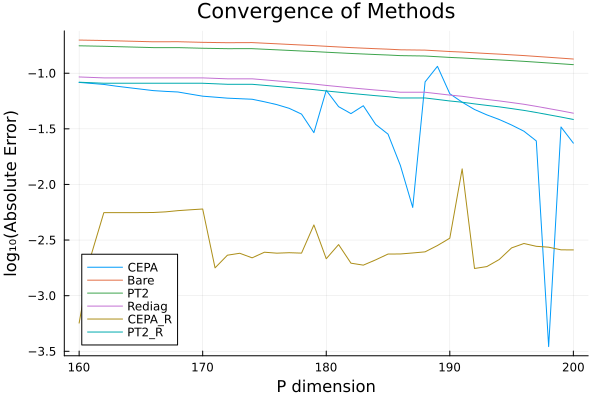

In [8]:
using Plots
# Compute error arrays
err_cepa = abs.(E_cepa .- E_exact)
err_acpf = abs.(E_acpf .- E_exact)
err_aqcc = abs.(E_aqcc .- E_exact)
err_bare = abs.(E_bare .- E_exact)
err_pt2 = abs.(E_pt2 .- E_exact)
err_rediag = abs.(E_rediag .- E_exact)
err_cepa_r = abs.(E_cepa_r .- E_exact)
err_pt2_r = abs.(E_PT2_R .- E_exact)


# Plot log10 errors vs p_dim (with Plots.jl)
using Plots
plot(p_dim, log10.(err_cepa), label="CEPA")
# plot!(p_dim, log10.(err_acpf), label="ACPF")
# plot!(p_dim, log10.(err_aqcc), label="AQCC")
plot!(p_dim, log10.(err_bare), label="Bare")
plot!(p_dim, log10.(err_pt2), label="PT2")
plot!(p_dim, log10.(err_rediag), label="Rediag")
plot!(p_dim, log10.(err_cepa_r), label="CEPA_R")
plot!(p_dim, log10.(err_pt2_r), label="PT2_R")
xlabel!("P dimension")
ylabel!("log₁₀(Absolute Error)")
title!("Convergence of Methods")
# savefig("convergence_plot_H8_cube.png")

